<a href="https://colab.research.google.com/github/RcrvzM/DM_PROYECTO-FINAL/blob/main/Proyecciones_economicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Instalar Java
!apt-get install openjdk-11-jdk -y

# 2. Descargar Spark desde un mirror alternativo
!wget https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

# 3. Descomprimir Spark
!tar -xvzf spark-3.3.2-bin-hadoop3.tgz

# 4. Instalar findspark
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PIB_Mundial").getOrCreate()

print("✅ Versión de Spark:", spark.version)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 5,366 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [2]:
#Fin de instalacion de Spark

In [3]:
#Incio de descarga de fuentes de datos

In [4]:
import requests, json

# API del Banco Mundial - PIB
url_pib = "http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?format=json&per_page=20000"
r_pib = requests.get(url_pib)
data_pib = r_pib.json()[1]

# Guardar como JSONL
with open("/content/pib.json", "w") as f:
    for record in data_pib:
        f.write(json.dumps(record) + "\n")


In [5]:
# API del Banco Mundial - Tasa de empleo (% de población)
url_empleo = "http://api.worldbank.org/v2/country/all/indicator/SL.EMP.TOTL.SP.ZS?format=json&per_page=20000"
r_empleo = requests.get(url_empleo)
data_empleo = r_empleo.json()[1]

# Guardar como JSONL
with open("/content/empleo.json", "w") as f:
    for record in data_empleo:
        f.write(json.dumps(record) + "\n")


In [6]:
import requests

# API SDMX del FMI – Tipo de cambio (ENDE_XDC_USD_RATE)
url_fx = "http://dataservices.imf.org/REST/SDMX_XML.svc/CompactData/IFS/A..ENDE_XDC_USD_RATE"

# Descargar archivo
r_fx = requests.get(url_fx)

# Guardar en disco (sin procesamiento aún)
with open("/content/fx.xml", "wb") as f:
    f.write(r_fx.content)


In [7]:
# Fin de descarga de fuentes de datos

In [8]:
# Inicio de validaciones de fuentes de datos

In [9]:
from pyspark.sql.functions import col

# Cargar archivos JSONL
df_pib = spark.read.json("/content/pib.json")
df_empleo = spark.read.json("/content/empleo.json")

# Función de validación de estructura
def validar_dataset(df, nombre, columnas):
    print(f"\n📊 Validando: {nombre}")
    errores = {}
    total = df.count()
    print(f"Total filas: {total}")

    for columna in columnas:
        nulos = df.filter(col(columna).isNull()).count()
        errores[columna] = nulos
        print(f"Nulos en '{columna}': {nulos}")

    return errores

# Validar PIB
validar_dataset(df_pib, "PIB", ["country.value", "date", "value"])

# Validar Empleo
validar_dataset(df_empleo, "Empleo", ["country.value", "date", "value"])



📊 Validando: PIB
Total filas: 17290
Nulos en 'country.value': 0
Nulos en 'date': 0
Nulos en 'value': 2983

📊 Validando: Empleo
Total filas: 17290
Nulos en 'country.value': 0
Nulos en 'date': 0
Nulos en 'value': 9309


{'country.value': 0, 'date': 0, 'value': 9309}

In [10]:
import xml.etree.ElementTree as ET

# Parsear el XML sin namespace
tree = ET.parse("/content/fx.xml")
root = tree.getroot()

# Extraer nodos <Series>
series_nodos = root.findall(".//{http://dataservices.imf.org/compact/IFS}Series")

print(f"📌 Total Series encontradas: {len(series_nodos)}")

# Extraer observaciones
data = []

for serie in series_nodos:
    pais = serie.attrib.get("REF_AREA")
    for obs in serie.findall("{http://dataservices.imf.org/compact/IFS}Obs"):
        anio = obs.attrib.get("TIME_PERIOD")
        valor = obs.attrib.get("OBS_VALUE")
        if pais and anio and valor:
            data.append((pais, int(anio), float(valor)))

# Ver resumen
print(f"✅ Total registros válidos: {len(data)}")
print("Ejemplo:", data[:5])


📌 Total Series encontradas: 226
✅ Total registros válidos: 13939
Ejemplo: [('NG', 1950, 0.714286), ('NG', 1951, 0.714286), ('NG', 1952, 0.714286), ('NG', 1953, 0.714286), ('NG', 1954, 0.714286)]


In [11]:
# Fin de validaciones de fuentes de datos

In [12]:
#Cargar SPARK

In [13]:
df_pib = spark.read.json("/content/pib.json")

# Filtrar registros útiles
df_pib_limpio = df_pib.filter(
    col("country.value").isNotNull() &
    col("date").isNotNull() &
    col("value").isNotNull()
)

# Renombrar columnas y tipos
df_pib_limpio = df_pib_limpio.select(
    col("country.value").alias("pais"),
    col("date").cast("int").alias("anio"),
    col("value").cast("double").alias("pib_usd")
)

df_pib_limpio.show(5)


+--------------------+----+-------------------+
|                pais|anio|            pib_usd|
+--------------------+----+-------------------+
|Africa Eastern an...|2023|1.24547247167595E12|
|Africa Eastern an...|2022|1.19142317624296E12|
|Africa Eastern an...|2021|1.08574517885097E12|
|Africa Eastern an...|2020|9.33391782089617E11|
|Africa Eastern an...|2019|1.00972117405491E12|
+--------------------+----+-------------------+
only showing top 5 rows



In [14]:
df_empleo = spark.read.json("/content/empleo.json")

# Filtrar registros válidos
df_empleo_limpio = df_empleo.filter(
    col("country.value").isNotNull() &
    col("date").isNotNull() &
    col("value").isNotNull()
)

# Renombrar columnas y tipos
df_empleo_limpio = df_empleo_limpio.select(
    col("country.value").alias("pais"),
    col("date").cast("int").alias("anio"),
    col("value").cast("double").alias("tasa_empleo")
)

df_empleo_limpio.show(5)


+--------------------+----+----------------+
|                pais|anio|     tasa_empleo|
+--------------------+----+----------------+
|Africa Eastern an...|2024|63.8048907252938|
|Africa Eastern an...|2023|63.8966859801838|
|Africa Eastern an...|2022|61.6567788664629|
|Africa Eastern an...|2021|61.0661154052549|
|Africa Eastern an...|2020|60.8607715076156|
+--------------------+----+----------------+
only showing top 5 rows



In [15]:
import csv

# Guardar la lista como archivo CSV
with open("/content/fx.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["pais", "anio", "tipo_cambio"])
    writer.writerows(data)


In [16]:
df_fx_limpio = spark.read.option("header", True).option("inferSchema", True).csv("/content/fx.csv")
df_fx_limpio.show(5)
df_fx_limpio.printSchema()


+----+----+-----------+
|pais|anio|tipo_cambio|
+----+----+-----------+
|  NG|1950|   0.714286|
|  NG|1951|   0.714286|
|  NG|1952|   0.714286|
|  NG|1953|   0.714286|
|  NG|1954|   0.714286|
+----+----+-----------+
only showing top 5 rows

root
 |-- pais: string (nullable = true)
 |-- anio: integer (nullable = true)
 |-- tipo_cambio: double (nullable = true)



In [17]:
#  Inicio  Descarga de Paises / Normalizacion

In [18]:
url_alt = "https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv"
r = requests.get(url_alt)

with open("/content/paises_codigos.csv", "wb") as f:
    f.write(r.content)

df_codigos = spark.read.option("header", True).option("inferSchema", True).csv("/content/paises_codigos.csv")

# Verificar columnas disponibles
df_codigos.columns[:10]


['FIFA',
 'Dial',
 'ISO3166-1-Alpha-3',
 'MARC',
 'is_independent',
 'ISO3166-1-numeric',
 'GAUL',
 'FIPS',
 'WMO',
 'ISO3166-1-Alpha-2']

In [19]:
# Normalizar código y nombre
df_codigos = df_codigos.select(
    col("ISO3166-1-Alpha-2").alias("pais_codigo"),
    col("official_name_en").alias("pais")
).filter(col("pais").isNotNull() & col("pais_codigo").isNotNull())

df_codigos.show(5)


+-----------+--------------+
|pais_codigo|          pais|
+-----------+--------------+
|         AF|   Afghanistan|
|         AX| Åland Islands|
|         AL|       Albania|
|         DZ|       Algeria|
|         AS|American Samoa|
+-----------+--------------+
only showing top 5 rows



In [20]:
# FIN  # Descarga de Paises / Normalizacion

In [21]:

df_codigos = spark.read.option("header", True).option("inferSchema", True).csv("/content/paises_codigos.csv")

df_codigos = df_codigos.select(
    col("ISO3166-1-Alpha-2").alias("pais_codigo"),
    col("official_name_en").alias("pais")
).filter(col("pais").isNotNull() & col("pais_codigo").isNotNull())

# Volver a crear df_fx_limpio si no lo tienes cargado
df_fx_limpio = spark.read.option("header", True).option("inferSchema", True).csv("/content/fx.csv")

# Hacer el join para obtener país con nombre completo
df_fx_final = df_fx_limpio.join(
    df_codigos,
    df_fx_limpio.pais == df_codigos.pais_codigo,
    "left"
).select(
    df_codigos.pais.alias("pais"),
    df_fx_limpio.anio,
    df_fx_limpio.tipo_cambio
)


In [22]:
#Union de fuentes de datos

In [23]:
df_base = df_pib_limpio.join(
    df_empleo_limpio,
    on=["pais", "anio"],
    how="inner"
)

df_base.show(5)
df_base.printSchema()


+--------------------+----+-------------------+----------------+
|                pais|anio|            pib_usd|     tasa_empleo|
+--------------------+----+-------------------+----------------+
|Africa Eastern an...|2023|1.24547247167595E12|63.8966859801838|
|Africa Eastern an...|2022|1.19142317624296E12|61.6567788664629|
|Africa Eastern an...|2021|1.08574517885097E12|61.0661154052549|
|Africa Eastern an...|2020|9.33391782089617E11|60.8607715076156|
|Africa Eastern an...|2019|1.00972117405491E12|62.6086595977002|
+--------------------+----+-------------------+----------------+
only showing top 5 rows

root
 |-- pais: string (nullable = true)
 |-- anio: integer (nullable = true)
 |-- pib_usd: double (nullable = true)
 |-- tasa_empleo: double (nullable = true)



In [24]:
df_final = df_base.join(
    df_fx_final,
    on=["pais", "anio"],
    how="inner"
)

df_final.show(10)
df_final.printSchema()


+-----------------+----+-------------------+-----------+-----------------+
|             pais|anio|            pib_usd|tasa_empleo|      tipo_cambio|
+-----------------+----+-------------------+-----------+-----------------+
|        Argentina|2010| 4.2362742209249E11|     55.544|            3.956|
|       Azerbaijan|2012|6.96799445041972E10|     58.398|            0.785|
|          Bahrain|2014|3.47725265957447E10|     70.357|            0.376|
|         Barbados|2019|         5.788288E9|     59.445|              2.0|
|           Brazil|2023|2.17366565593727E12|     57.915|           4.8407|
|           Brazil|1997|8.83206179730462E11|     58.954|           1.1164|
|         Colombia|2014|3.81240864422407E11|     61.096|          2392.46|
|           Cyprus|1999| 1.0497907227616E10|     57.138|0.574580556193978|
|Equatorial Guinea|1995| 1.41853360867855E8|     57.114|  489.99965339216|
|        Guatemala|2020|  7.771946422073E10|     55.219|         7.795435|
+-----------------+----+-

In [25]:
# Inicio Validacion de datos unificados

In [26]:
from pyspark.sql.functions import col

df_final.select([
    col(c).isNull().cast("int").alias(c + "_is_null")
    for c in df_final.columns
]).groupBy().sum().show()


+-----------------+-----------------+--------------------+------------------------+------------------------+
|sum(pais_is_null)|sum(anio_is_null)|sum(pib_usd_is_null)|sum(tasa_empleo_is_null)|sum(tipo_cambio_is_null)|
+-----------------+-----------------+--------------------+------------------------+------------------------+
|                0|                0|                   0|                       0|                       0|
+-----------------+-----------------+--------------------+------------------------+------------------------+



In [27]:
df_final.describe(["pib_usd", "tasa_empleo", "tipo_cambio"]).show()


+-------+--------------------+------------------+------------------+
|summary|             pib_usd|       tasa_empleo|       tipo_cambio|
+-------+--------------------+------------------+------------------+
|  count|                4606|              4606|              4606|
|   mean|2.053654044773038...| 56.97124164133726|1620.4518299894435|
| stddev|8.781787797406036E11|12.348303065208583| 72227.24892523536|
|    min|  7.22854038423458E7|            19.886|           1.5E-10|
|    max| 1.78817826837073E13|            87.461|  4900000.00000001|
+-------+--------------------+------------------+------------------+



In [28]:
df_final.groupBy("pais").count().orderBy("count", ascending=False).show(10)


+--------+-----+
|    pais|count|
+--------+-----+
|Malaysia|   33|
|    Chad|   33|
|    Fiji|   33|
|Paraguay|   33|
|  Malawi|   33|
|  Sweden|   33|
|    Iraq|   33|
|  Guyana|   33|
| Comoros|   33|
|Djibouti|   33|
+--------+-----+
only showing top 10 rows



In [29]:
# Fin de validacion de datos unificados

In [30]:
df_final.write \
    .mode("overwrite") \
    .parquet("/content/df_final.parquet")


In [31]:
# Inicio de Analisis Exploratorio Pruebas y validacion de datos

In [32]:
df_final.groupBy("pais") \
    .avg("pib_usd") \
    .withColumnRenamed("avg(pib_usd)", "pib_promedio") \
    .orderBy("pib_promedio", ascending=False) \
    .show(10, truncate=False)


+------------------+---------------------+
|pais              |pib_promedio         |
+------------------+---------------------+
|China             |6.230473887484121E12 |
|Japan             |4.838522473669395E12 |
|Germany           |2.2346984879222773E12|
|France            |1.4361547669667334E12|
|India             |1.396714751056205E12 |
|Brazil            |1.3389622631690845E12|
|Canada            |1.2632316330121458E12|
|Italy             |1.2189154297405476E12|
|Russian Federation|1.1293585244552412E12|
|Mexico            |9.51901395319106E11  |
+------------------+---------------------+
only showing top 10 rows



In [33]:
df_final.select("pais", "anio", "pib_usd", "tipo_cambio") \
    .orderBy("pais", "anio") \
    .show(20)


+-----------+----+-------------------+-----------+
|       pais|anio|            pib_usd|tipo_cambio|
+-----------+----+-------------------+-----------+
|Afghanistan|2000| 3.52141805992345E9|    47.5048|
|Afghanistan|2001| 2.81357175387253E9|  47.258979|
|Afghanistan|2002| 3.82570143899963E9|     47.263|
|Afghanistan|2003| 4.52094681854581E9|     48.865|
|Afghanistan|2004| 5.22489671867782E9|      48.22|
|Afghanistan|2005| 6.20325653870967E9|      50.41|
|Afghanistan|2006| 6.97175828229351E9|      49.85|
|Afghanistan|2007| 9.74788618739393E9|      49.72|
|Afghanistan|2008|1.01092970475432E10|      52.14|
|Afghanistan|2009|1.24161527320567E10|      48.74|
|Afghanistan|2010|1.58566685558336E10|      45.27|
|Afghanistan|2011|1.78050982063141E10|      49.04|
|Afghanistan|2012|1.99073297775872E10|      52.14|
|Afghanistan|2013|2.01464167575987E10|      56.64|
|Afghanistan|2014|2.04971285556972E10|      57.82|
|Afghanistan|2015|1.91342216447325E10|      68.05|
|Afghanistan|2016|1.81165723950

In [34]:
df_final.groupBy("pais") \
    .avg("tasa_empleo") \
    .withColumnRenamed("avg(tasa_empleo)", "empleo_promedio") \
    .orderBy("empleo_promedio", ascending=False) \
    .show(10, truncate=False)


+---------------+-----------------+
|pais           |empleo_promedio  |
+---------------+-----------------+
|Qatar          |84.38260606060607|
|Madagascar     |82.66660606060604|
|Solomon Islands|82.58387878787879|
|Cambodia       |80.45896969696969|
|Mozambique     |79.79615151515154|
|Burundi        |79.47681818181817|
|Nigeria        |78.98330303030305|
|Ethiopia       |76.746           |
|Niger          |75.99939393939393|
|Eritrea        |75.60645         |
+---------------+-----------------+
only showing top 10 rows



In [35]:
df_final.filter(col("pais") == "Mexico") \
    .orderBy("anio") \
    .select("anio", "tipo_cambio") \
    .show()


+----+-----------+
|anio|tipo_cambio|
+----+-----------+
|1991|      3.071|
|1992|     3.1154|
|1993|     3.1059|
|1994|      5.325|
|1995|     7.6425|
|1996|     7.8509|
|1997|     8.0833|
|1998|      9.865|
|1999|     9.5143|
|2000|     9.5722|
|2001|     9.1423|
|2002|    10.3125|
|2003|     11.236|
|2004|    11.2648|
|2005|    10.7777|
|2006|     10.881|
|2007|    10.8662|
|2008|    13.5383|
|2009|    13.0587|
|2010|    12.3571|
+----+-----------+
only showing top 20 rows



In [36]:
df_final.select("pais", "anio", "pib_usd", "tipo_cambio") \
    .orderBy("pais", "anio") \
    .show(20)


+-----------+----+-------------------+-----------+
|       pais|anio|            pib_usd|tipo_cambio|
+-----------+----+-------------------+-----------+
|Afghanistan|2000| 3.52141805992345E9|    47.5048|
|Afghanistan|2001| 2.81357175387253E9|  47.258979|
|Afghanistan|2002| 3.82570143899963E9|     47.263|
|Afghanistan|2003| 4.52094681854581E9|     48.865|
|Afghanistan|2004| 5.22489671867782E9|      48.22|
|Afghanistan|2005| 6.20325653870967E9|      50.41|
|Afghanistan|2006| 6.97175828229351E9|      49.85|
|Afghanistan|2007| 9.74788618739393E9|      49.72|
|Afghanistan|2008|1.01092970475432E10|      52.14|
|Afghanistan|2009|1.24161527320567E10|      48.74|
|Afghanistan|2010|1.58566685558336E10|      45.27|
|Afghanistan|2011|1.78050982063141E10|      49.04|
|Afghanistan|2012|1.99073297775872E10|      52.14|
|Afghanistan|2013|2.01464167575987E10|      56.64|
|Afghanistan|2014|2.04971285556972E10|      57.82|
|Afghanistan|2015|1.91342216447325E10|      68.05|
|Afghanistan|2016|1.81165723950

In [37]:
df_final.groupBy("pais") \
    .avg("tasa_empleo") \
    .withColumnRenamed("avg(tasa_empleo)", "empleo_promedio") \
    .orderBy("empleo_promedio", ascending=False) \
    .show(10, truncate=False)


+---------------+-----------------+
|pais           |empleo_promedio  |
+---------------+-----------------+
|Qatar          |84.38260606060607|
|Madagascar     |82.66660606060604|
|Solomon Islands|82.58387878787879|
|Cambodia       |80.45896969696969|
|Mozambique     |79.79615151515154|
|Burundi        |79.47681818181817|
|Nigeria        |78.98330303030305|
|Ethiopia       |76.746           |
|Niger          |75.99939393939393|
|Eritrea        |75.60645         |
+---------------+-----------------+
only showing top 10 rows



In [38]:
#fin de pruebas y validacion de datos

In [79]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

def entrenar_y_graficar_pais(df_final, pais_objetivo="Mexico", variable_objetivo="tipo_cambio"):
    # 1. Filtrar país
    df_pais = df_final.filter(df_final.pais == pais_objetivo)

    # 2. Indexar país
    indexer = StringIndexer(inputCol="pais", outputCol="pais_index")
    df_indexado = indexer.fit(df_pais).transform(df_pais)

    # 3. Preparar features
    features = [col for col in ["anio", "pib_usd", "tasa_empleo"] if col != variable_objetivo]
    features.append("pais_index")

    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df_vector = assembler.transform(df_indexado).select("anio", *features, variable_objetivo, "features").withColumnRenamed(variable_objetivo, "label")

    # 4. Entrenar modelo
    lr = LinearRegression(featuresCol="features", labelCol="label")
    modelo = lr.fit(df_vector)
    evaluacion = modelo.evaluate(df_vector)

    # 5. Mostrar resultados
    print(f"📍 Resultados del modelo para {pais_objetivo}")
    print("R²:", round(evaluacion.r2, 4))
    print("RMSE:", round(evaluacion.rootMeanSquaredError, 4))
    print("MAE:", round(evaluacion.meanAbsoluteError, 4))
    print("Coeficientes:", modelo.coefficients)
    print("Intercepto:", modelo.intercept)

    # 6. Predicciones y gráfico con etiquetas
    df_pred = modelo.transform(df_vector).select("anio", "label", "prediction").toPandas()

    plt.figure(figsize=(10, 5))
    plt.plot(df_pred["anio"], df_pred["label"], label="Valor real", marker="o")
    plt.plot(df_pred["anio"], df_pred["prediction"], label="Predicción", linestyle="--", marker="x")

    # Mostrar etiquetas de valor en cada punto de predicción
    for i in range(len(df_pred)):
        plt.text(df_pred["anio"][i], df_pred["prediction"][i],
                 f"${df_pred['prediction'][i]:.2f}", fontsize=9, ha='center', va='bottom', color="black")

    plt.title(f"📊 Proyección del Tipo de Cambio en {pais_objetivo}")
    plt.xticks(df_pred["anio"].unique(), rotation=45)
    plt.ylabel("Tipo de Cambio (USD)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression

def entrenar_y_graficar_proyeccion(df_final, pais_objetivo="Mexico", variable_objetivo="tipo_cambio", año_corte=2022, años_futuros=4):
    # 1. Preparar datos
    df_pais = df_final.filter(df_final.pais == pais_objetivo)
    indexer = StringIndexer(inputCol="pais", outputCol="pais_index")
    df_indexado = indexer.fit(df_pais).transform(df_pais)

    features = [c for c in ["anio", "pib_usd", "tasa_empleo"] if c != variable_objetivo]
    features.append("pais_index")
    assembler = VectorAssembler(inputCols=features, outputCol="features")

    # 2. Entrenamiento hasta el año de corte
    df_hist = df_indexado.filter(df_indexado.anio <= año_corte)
    df_vector = assembler.transform(df_hist).select("anio", *features, variable_objetivo, "features").withColumnRenamed(variable_objetivo, "label")
    modelo = LinearRegression(featuresCol="features", labelCol="label").fit(df_vector)

    # 3. Crear proyección
    ultimo = df_hist.orderBy("anio", ascending=False).limit(1).toPandas().iloc[0]
    vals_base = {f: float(ultimo[f]) for f in features if f != "anio"}
    futuros = []
    for i in range(1, años_futuros + 1):
        entrada = {
            "anio": int(ultimo["anio"]) + i,
            "pais_index": vals_base["pais_index"]
        }
        if "pib_usd" in features:
            entrada["pib_usd"] = vals_base["pib_usd"] * (1.03 ** i)
        if "tasa_empleo" in features:
            entrada["tasa_empleo"] = vals_base["tasa_empleo"] + 0.2 * i
        futuros.append(entrada)

    df_futuro = spark.createDataFrame(pd.DataFrame(futuros))
    df_futuro_vector = assembler.transform(df_futuro)
    pred_futuro = modelo.transform(df_futuro_vector).select("anio", "prediction").toPandas()

    # 4. Predicción sobre históricos
    historico = modelo.transform(df_vector).select("anio", "label", "prediction").toPandas()
    historico = historico.dropna().sort_values("anio")

    # 5. Graficar
    plt.figure(figsize=(10, 5))
    plt.plot(historico["anio"], historico["label"], label="Valor real", color="blue", marker="o", linestyle="-")
    plt.plot(historico["anio"], historico["prediction"], label="Predicción histórica", color="skyblue", linestyle="--", marker="x")
    plt.plot(pred_futuro["anio"], pred_futuro["prediction"], label="Proyección futura", color="orange", linestyle="--", marker="x")

    # Etiquetas en puntos futuros
    for _, row in pred_futuro.iterrows():
        plt.text(row["anio"], row["prediction"], f"${row['prediction']:.2f}", fontsize=9, ha='center', va='bottom')

    # Línea vertical de corte
    plt.axvline(x=año_corte + 0.5, color='gray', linestyle=':', linewidth=1)
    plt.text(año_corte + 0.5, plt.ylim()[1]*0.95, 'Inicio proyección', rotation=90, va='top', ha='right')

    # Formato final
    plt.title(f"📊 Tipo de Cambio en {pais_objetivo}: Real vs Proyección")
    plt.xlabel("Año")
    plt.ylabel("Tipo de Cambio (USD)")
    plt.xticks(list(historico["anio"].unique()) + list(pred_futuro["anio"].unique()), rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


📍 Resultados del modelo para Mexico
R²: 0.9609
RMSE: 1.012
MAE: 0.8584
Coeficientes: [0.8935414171983743,-1.1037892043536777e-11,0.3828599611411305,0.0]
Intercepto: -1792.5016230021602


<ipython-input-79-16c4ae7b06df>:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


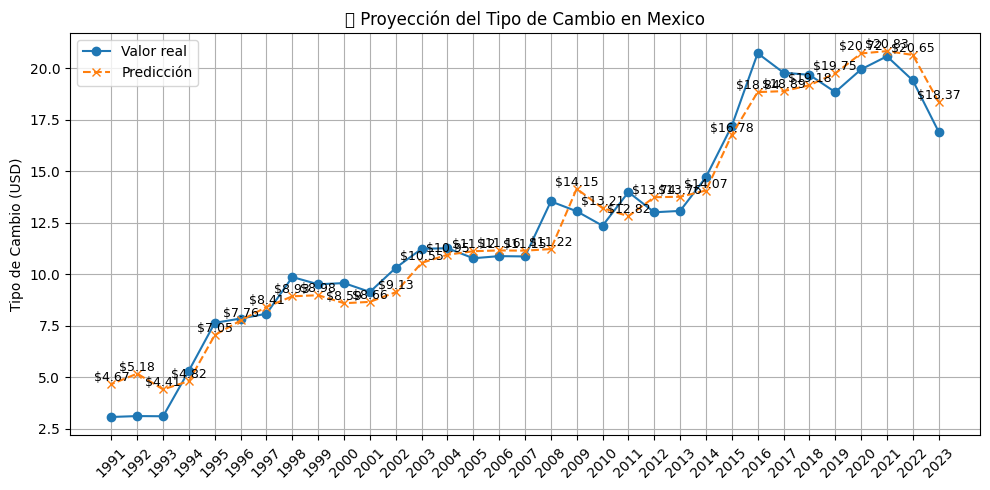

In [87]:
entrenar_y_graficar_pais(df_final, pais_objetivo="Mexico")



In [ ]:
# Prueba de entrenamiento global entrenado

In [54]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression

# Indexar países
indexer = StringIndexer(inputCol="pais", outputCol="pais_index")
df_indexado = indexer.fit(df_final).transform(df_final)

# Features incluyendo país_index
variable_objetivo = "tipo_cambio"
features = [col for col in ["anio", "pib_usd", "tasa_empleo"] if col != variable_objetivo]
features.append("pais_index")

# Ensamblar vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vector = assembler.transform(df_indexado).select("pais", *features, variable_objetivo, "features").withColumnRenamed(variable_objetivo, "label")

# Entrenar modelo global
lr = LinearRegression(featuresCol="features", labelCol="label")
modelo_global = lr.fit(df_vector)

# Evaluar modelo global
evaluacion = modelo_global.evaluate(df_vector)

print("✅ Modelo global entrenado.")
print("R²:", round(evaluacion.r2, 4))
print("RMSE:", round(evaluacion.rootMeanSquaredError, 4))
print("MAE:", round(evaluacion.meanAbsoluteError, 4))
print("Coeficientes:", modelo_global.coefficients)


✅ Modelo global entrenado.
R²: 0.0008
RMSE: 72189.3526
MAE: 3339.8067
Coeficientes: [54.6650551268906,-2.1901394481731463e-10,80.5904101825595,47.36846329731525]


In [ ]:
# Fin de entrenamientoi global , / Resultados no adecuados